# NEU502b fMRI Respiration Blocks

In [1]:
import os, warnings
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv, concat
from scripts.utilities import read_gifti
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define metadata.
func_dir = 'preproc/fmriprep'
subjects = ['sub-01','sub-02']
tasks = ['breathholdcontrol', 'hyperventilatecontrol']
spaces = ['fsaverage5.L','fsaverage5.R']

/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Step 1: Extract Timecourses

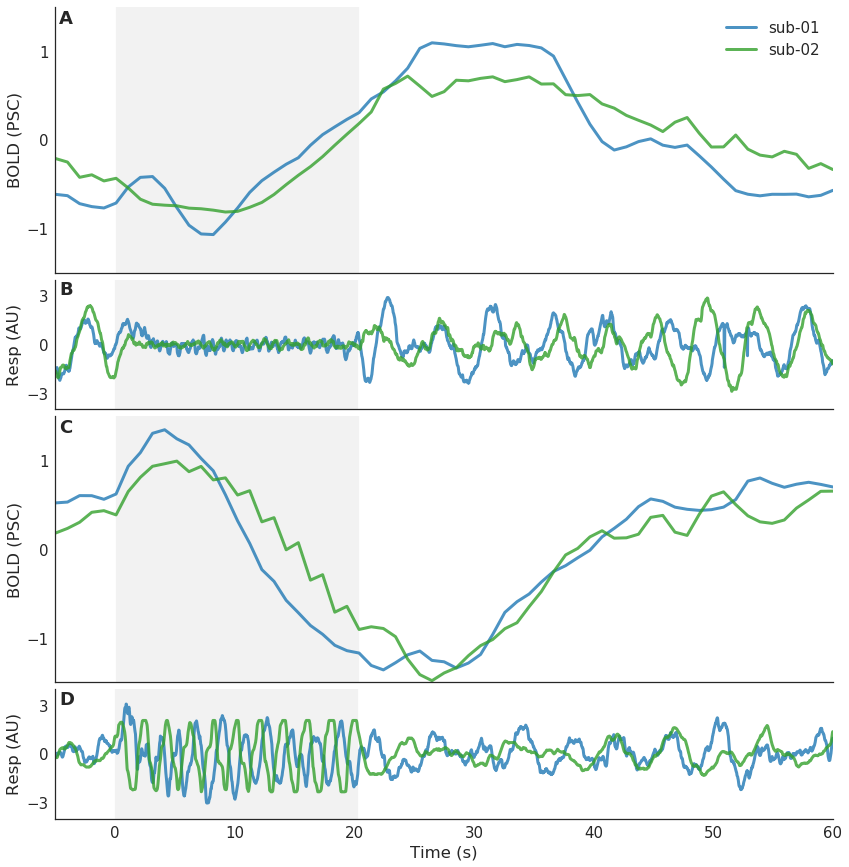

In [2]:
from pandas import read_table

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define metadata.
n_acq = 370

## Define onset times.
onsets = np.arange(10,n_acq,60)
start = -5

## Define respiration parameters.
sfreq = 50

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare global signal.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
brain = np.zeros((len(tasks), len(subjects), n_acq))

for i, task in enumerate(tasks):
    
    for j, subj in enumerate(subjects):
        
        for space in spaces:
            
            ## Load task data.
            f = os.path.join('first_levels',task,'%s_task-%s_space-%s.psc.npz' %(subj,task,space))
            npz = np.load(f)

            ## Prepare data.
            data, mask = npz['psc'], npz['mask']
            y = data[:,mask]
            
            ## Average and append.
            brain[i,j] += y.mean(axis=-1)
            
## Average over hemispheres.
brain /= 2

## Realign data to start of instructions.
brain = [brain[...,onsets[i]+start:onsets[i+1]] for i in np.arange(onsets.size-1)]
brain = np.mean(brain, axis=0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare respiration.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
resp = np.zeros((len(tasks), len(subjects), n_acq * sfreq))

for i, task in enumerate(tasks):
    
    for j, subj in enumerate(subjects):
                    
        ## Load task data.
        f = os.path.join('raw',subj,'func','%s_task-%s_acq-respiratory_physio.tsv.gz' %(subj,task))
        y = read_table(f, sep='\t', header=None).values.squeeze()

        ## Average and append.
        resp[i,j] += y
            
## Realign data to start of instructions.
times = np.arange(0, n_acq, 1/sfreq)
resp = [resp[...,np.logical_and(times >= onsets[i]+start+1, times <= onsets[i+1]+1)] 
        for i in np.arange(onsets.size-1)]
resp = np.mean(resp, axis=0)[...,:-1]
resp = np.apply_along_axis(lambda arr: (arr - arr.mean()) / arr.std(), -1, resp)
times = np.arange(-5,60,1/sfreq)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(12,12))
colors = ['#1f78b4','#33a02c']

## Breathhold control: BOLD.
ax = plt.subplot2grid((6,1),(0,0),rowspan=2)
for arr, color, label in zip(brain[0], colors, ['sub-01','sub-02']):
    ax.plot(np.arange(-5,60), arr, lw=3, label=label, color=color, alpha=0.8)
    
## Add info.
ax.fill_between([0,20], -1.5, 1.5,  color='0.95')
ax.set(xlim=(-5,59), xticks=[], ylim=(-1.5,1.5), 
       yticks=[-1,0,1], ylabel='BOLD (PSC)')
ax.annotate('A', (0,0), (5e-3,0.99), 'axes fraction', fontsize=18,
            weight='semibold', va='top', ha='left')
ax.legend(loc=1)

## Breathhold control: respiratory.
ax = plt.subplot2grid((6,1),(2,0),rowspan=1)
for arr, color, label in zip(resp[0], colors, ['sub-01','sub-02']):
    ax.plot(times, arr, lw=3, label=label, color=color, alpha=0.8)

## Add info.
ax.fill_between([0,20.3], -4, 4,  color='0.95')
ax.set(xlim=(-5,60), xticks=[], ylim=(-4, 4), 
       yticks=[-3,0,3], ylabel='Resp (AU)')
ax.annotate('B', (0,0), (5e-3,0.99), 'axes fraction', fontsize=18,
            weight='semibold', va='top', ha='left')

## Hyperventilate control: BOLD.
ax = plt.subplot2grid((6,1),(3,0),rowspan=2)
for arr, color, label in zip(brain[1], colors, ['sub-01','sub-02']):
    ax.plot(np.arange(-5,60), arr, lw=3, label=label, color=color, alpha=0.8)

## Add info.
ax.fill_between([0,20], -1.5, 1.5,  color='0.95')
ax.set(xlim=(-5,59), xticks=[], ylim=(-1.5,1.5), 
       yticks=[-1,0,1], ylabel='BOLD (PSC)')
ax.annotate('C', (0,0), (5e-3,0.99), 'axes fraction', fontsize=18,
            weight='semibold', va='top', ha='left')

## Hyperventilate control: respiratory.
ax = plt.subplot2grid((6,1),(5,0),rowspan=1)
for arr, color, label in zip(resp[1], colors, ['sub-01','sub-02']):
    ax.plot(times, arr, lw=3, label=label, color=color, alpha=0.8)

## Add info.
ax.fill_between([0,20.3], -4, 4,  color='0.95')
ax.set(xlim=(-5,60), xlabel='Time (s)', ylim=(-4, 4), 
       yticks=[-3,0,3], ylabel='Resp (AU)')
ax.annotate('D', (0,0), (5e-3,0.99), 'axes fraction', fontsize=18,
            weight='semibold', va='top', ha='left')

sns.despine()
plt.subplots_adjust(left=0.075, right=0.975, top=0.99, bottom=0.05, hspace=0.05)
plt.savefig('plots/fig3/artifact.png', dpi=180)